In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

%matplotlib inline

C:\Users\danim\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:

X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
conv_layers = {}

In [26]:
def forward_propagation(X, parameters):

    W1 = parameters['W1']
    W2 = parameters['W2']

    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')

    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')

    A2 = tf.nn.relu(Z2)

    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    P2 = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(inputs=P2,activation_fn=None, num_outputs=6)
    l2reg = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2)
    return Z3, l2reg

In [27]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0009, beta = .01,
          num_epochs = 500, minibatch_size = 64, print_cost = True):

    ops.reset_default_graph()# to be able to rerun the model without overwriting tf variables
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        

    X = tf.placeholder(shape=(None, n_H0, n_W0, n_C0), dtype=tf.float32)
    Y = tf.placeholder(shape=(None, n_y), dtype=tf.float32)
 
    parameters = {}
    parameters['W1'] = tf.get_variable('W1', [4,4,3,8], initializer = tf.contrib.layers.xavier_initializer(seed=0))
    parameters['W2'] = tf.get_variable('W2', [2,2,8,16], initializer = tf.contrib.layers.xavier_initializer(seed=0))

    Z3, l2reg = forward_propagation(X, parameters)

    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))
    
    cost = tf.reduce_mean(cost + beta*l2reg)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        
        sess.run(init)
        
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed=1)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                minibatch_cost += temp_cost / num_minibatches
                

            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 2.034150
Cost after epoch 5: 1.951064
Cost after epoch 10: 1.914420
Cost after epoch 15: 1.828600
Cost after epoch 20: 1.606451
Cost after epoch 25: 1.370245
Cost after epoch 30: 1.211944
Cost after epoch 35: 1.095595
Cost after epoch 40: 1.009907
Cost after epoch 45: 0.941872
Cost after epoch 50: 0.887671
Cost after epoch 55: 0.843950
Cost after epoch 60: 0.807234
Cost after epoch 65: 0.775058
Cost after epoch 70: 0.748680
Cost after epoch 75: 0.725542
Cost after epoch 80: 0.704945
Cost after epoch 85: 0.686399
Cost after epoch 90: 0.670178
Cost after epoch 95: 0.655395
Cost after epoch 100: 0.642027
Cost after epoch 105: 0.629597
Cost after epoch 110: 0.618173
Cost after epoch 115: 0.607710
Cost after epoch 120: 0.597308
Cost after epoch 125: 0.587547
Cost after epoch 130: 0.578939
Cost after epoch 135: 0.570703
Cost after epoch 140: 0.562916
Cost after epoch 145: 0.555952
Cost after epoch 150: 0.548961
Cost after epoch 155: 0.542971
Cost after epoch 160: 0.537093

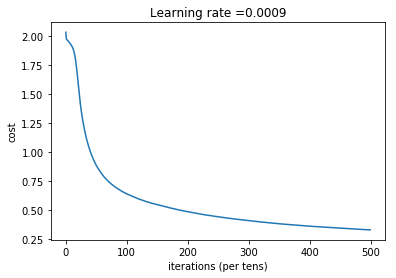

Tensor("Mean_2:0", shape=(), dtype=float32)
Train Accuracy: 0.97962964
Test Accuracy: 0.875


In [28]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)